In [1]:
import os 
import sys
import ast
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import fbprophet as pro

%matplotlib inline

# 1. Importing data

## 1.1 Pageview and revisions

In [2]:
combined_data = pd.read_csv('../data/test15/cleaned/combined.csv')
combined_data.timestamp = pd.to_datetime(combined_data.timestamp)
# In the interest of memory I'm going to immeadiately subset the combined data
combined_data = combined_data[['timestamp', 'revid', 'page_title', 'character_count', 
                               'external_link_count', 'heading_count', 'page_views',
                               'wikifile_count', 'wikilink_count', 'word_count']]

# combined_data = combined_data.reset_index()
# combined_data = combined_data.set_index(['page_title', 'timestamp'])

In [3]:
combined_data.sort_values(by=['page_title', 'timestamp'], inplace=True)

In [4]:
combined_data.head()

,timestamp,revid,page_title,character_count,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
0,2015-07-01,NaN,'Amran,NaN,NaN,NaN,14.0,NaN,NaN,NaN
1,2015-07-02,NaN,'Amran,NaN,NaN,NaN,12.0,NaN,NaN,NaN
2,2015-07-03,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN
3,2015-07-04,NaN,'Amran,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,2015-07-05,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN


## 1.2 Category data

In [5]:
category_data = pd.read_csv('../data/test15/cleaned/category_data.csv')

In [6]:
category_data.head()

,Unnamed: 0,page_title,revid,categories
0,0,Aubre de Lambert Maynard,786130355.0,[]
1,1,Nabla,715468992.0,[]
2,2,President-elect of the United States,670644904.0,"['Titles', 'Elections in the United States']"
3,3,Space Oddity,672181778.0,"['1975 singles', 'Song recordings produced by ..."
4,4,Tillakaratne Dilshan,669932370.0,"['Sri Lankan Buddhists', 'People from Western ..."


## 1.3 Links pointing to pages

In [7]:
pointer_data = pd.read_csv('../data/test15/cleaned/pointers.csv')

In [8]:
pointer_data.head()

,Unnamed: 0,page_title,talk_link_count,wiki_link_count,wikipeida_count,user_count
0,15,'Amran,1,68,0,0
1,16,'Amran Governorate,1,103,0,0
2,17,'Asir Region,9,97,0,0
3,19,'Hours...',10,7,0,0
4,20,+1 button,0,2,0,0


# 2 Processing data

## 2.1 Selecting categories

In [9]:
category_dict = {}
# category_data.set_index('page_title', inplace=True)

for page_title, df in category_data.iterrows():
    # lists were converted to a single string parsing them with ast
    for category in ast.literal_eval(df['categories']):
        try:
            category_dict[category] += 1
        except:
            category_dict[category] = 1


In [10]:
category_df = pd.DataFrame.from_dict(category_dict, orient='index')

In [11]:
category_df = category_df.sort_values(by=0, ascending=False)

In [137]:
category_df.iloc[:25]

,0
Living people,957
Articles containing video clips,195
American people of Irish descent,101
American people of English descent,100
Grammy Award winners,99
21st-century American writers,79
Battles of World War I involving Germany,78
World Digital Library related,77
20th-century American writers,75
American people of German descent,73


In [13]:
# subsetting a selection of categories

list_of_categories = ['Living people', 'Grammy Award winners', 
                      '21st-century American writers', '20th-century American writers',
                      'Member states of the United Nations', 'American films',
                      'American political writers', 'Machine learning']

In [14]:
# Pulling out the page titles which have these pages

category_dict = {}
category_data.set_index('page_title', inplace=True)

for page, df in category_data.iterrows():
    for category in ast.literal_eval(df['categories']):
        if category in list_of_categories:
            try:
                category_dict[category].append(page)
            except:
                category_dict[category] = [page]

Categories on wikiedia are all over the place and it looks like supercategories don't exist. For example - there are many instances of battles in the above list (Battles of the Western Front (World War I), Battles of World War I involving France), but there is no "Battles" category.

It is possible that these will need to be futher clustered or it means that I will have to consider a different sampling technique to collectdata.

## 2.2 Reducing wikipedia edits to counts

Instead of knowing specific details of each edit it would be nice to know the number of edits that wikipedia page experinced in a single day

In [ ]:
# Generating summary numbers for edits

combined_data.set_index('timestamp', inplace=True)
number_of_edits = combined_data[['revid', 'page_title']].groupby('page_title')['revid'].resample('1d').count()
number_of_edits = number_of_edits.to_frame(name='number_of_edits')

In [54]:
number_of_edits.reset_index(inplace=True)

number_of_edits.set_index(['page_title', 'timestamp'], inplace=True)

combined_data.reset_index(inplace=True)
combined_data.set_index(['page_title', 'timestamp'],inplace=True)

combined_data = pd.concat([combined_data, number_of_edits], sort=False)
combined_data = combined_data.sort_index(level=1).sort_index(level=0)

# Resampling to deal with difficulties in aligning data

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
combined_data = combined_data.groupby('page_title').resample('1d').mean()

In [17]:
# let's resample this data by years taking the average

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
resampled_data = combined_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 'word_count', 'number_of_edits']].groupby('page_title').resample('1d').mean()

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp')
resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())

# After filling the NA we can get a yearly average for our data

resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)

resampled_data = resampled_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 
                                 'word_count', 'number_of_edits']].groupby('page_title').resample('1y').mean()

resampled_data.reset_index(inplace=True)

## 2.3 Combining backlink data with edits and pageviews

Currently backlink data only exists for the most recent version of the website. As there are likely seasonal effects of a website we'll assume that a yearly average is representative of current activity. 

In [89]:
resampled_data.set_index('timestamp', inplace=True)

# We subset our data to only consider the current year
resampled_data = resampled_data.loc['2018-12-31']

pages = set(resampled_data.page_title) & set(pointer_data.page_title)

print('Number of pages before downselecting', len(set(resampled_data.page_title)))
print('Number of pages after downselecting', len(set(pages)))

resampled_data = resampled_data[resampled_data.page_title.isin(pages)]

# Subsetting the pointer data to only include shared pages

pointer_data = pointer_data[pointer_data.page_title.isin(pages)]
pointer_data.set_index('page_title', inplace=True)

resampled_data.reset_index(inplace=True)
resampled_data.set_index(['page_title'], inplace=True)

resampled_data['backlink_wikilink_count'] = pointer_data['wiki_link_count']
resampled_data['backlink_wikitalk_count'] = pointer_data['talk_link_count']

resampled_data = resampled_data.dropna()

AttributeError: 'DataFrame' object has no attribute 'page_title'

## 2.4 Visualizing data and transforming as necessary

The majority of the metrics that are considered are unbounded and are therefore likely right skewed. Here we visualize this data to deterimine what parameters need to be rescaled. As all of these data are >= 0 if rescaling is necessary data >0 will be log10 transformed.

### 2.4.1 Pageviews

In [99]:
resampled_data = resampled_data[(resampled_data.page_views > 0) & 
                                (resampled_data.word_count > 0)]

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


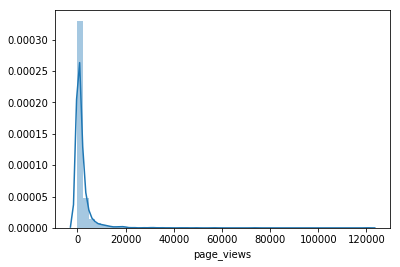

In [100]:
sns.distplot(resampled_data.page_views);

The page view data is clearly skewed - so we'll normalize this using a log 10 transform. 

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


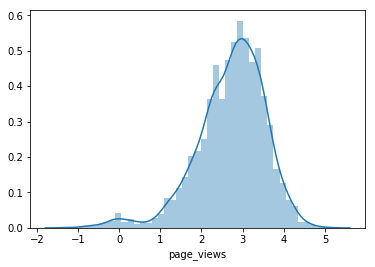

In [101]:
sns.distplot(np.log10(resampled_data.page_views));

In [102]:
# Saving this metric to our DF
resampled_data['log10_page_views'] = np.log10(resampled_data.page_views)

### 2.4.2 Word count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


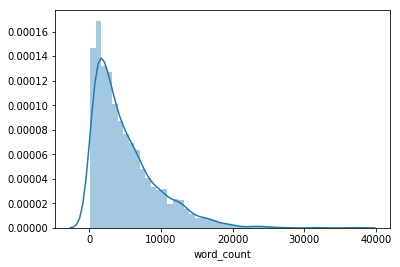

In [103]:
# Investigating word count

sns.distplot(resampled_data.word_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


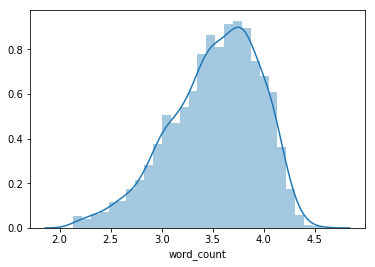

In [104]:
sns.distplot(np.log10(resampled_data.word_count))

Intersetingly this is bimodal ditribution.

In [105]:
resampled_data['log10_word_count'] = np.log10(resampled_data.word_count)

### 2.4.3 Wikilink count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


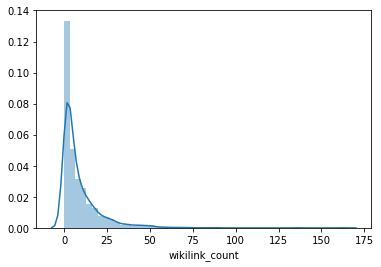

In [106]:
sns.distplot(resampled_data.wikilink_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


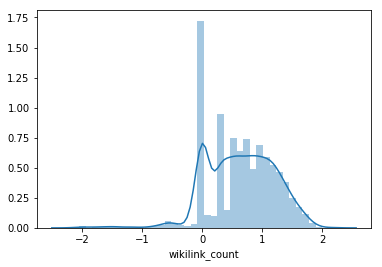

In [107]:
sns.distplot(np.log10(resampled_data[resampled_data.wikilink_count >0].wikilink_count))

In [108]:
resampled_data = resampled_data[resampled_data.wikilink_count >0]
resampled_data['log10_wikilink_count'] = np.log10(resampled_data.wikilink_count)

### External link count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


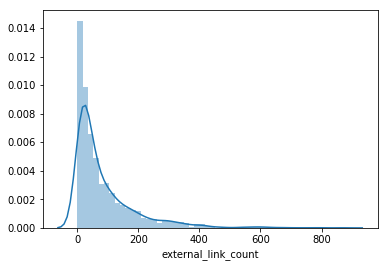

In [110]:
sns.distplot(resampled_data.external_link_count)

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


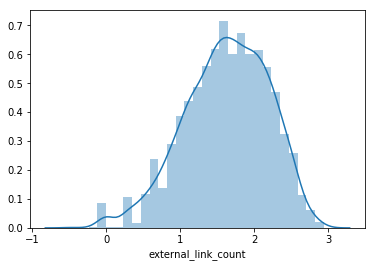

In [111]:
sns.distplot(np.log10(resampled_data[resampled_data.external_link_count >0].external_link_count))

In [112]:
resampled_data = resampled_data[resampled_data.external_link_count >0]
resampled_data['log10_external_link_count'] = np.log10(resampled_data.external_link_count)

### Wikifile count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


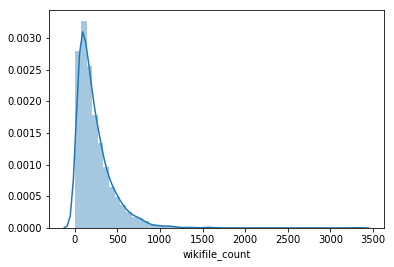

In [113]:
sns.distplot(resampled_data.wikifile_count)

In [114]:
resampled_data = resampled_data[resampled_data.wikifile_count >0]

resampled_data['log10_wikifile_count'] = np.log10(resampled_data.wikifile_count)

### Backlink count

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


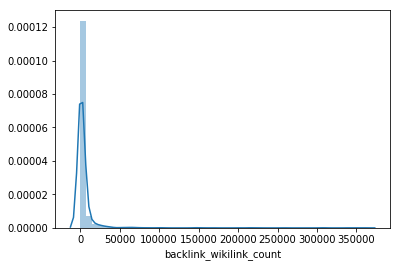

In [115]:
sns.distplot((resampled_data[resampled_data.backlink_wikilink_count >0].backlink_wikilink_count))

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


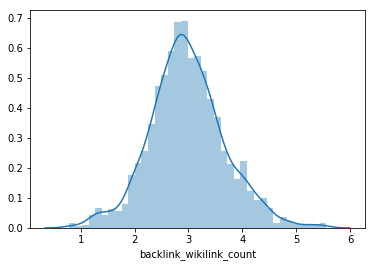

In [116]:
sns.distplot(np.log10(resampled_data[resampled_data.backlink_wikilink_count >0].backlink_wikilink_count))

In [117]:
resampled_data['log10_backlink_wikilink_count'] = np.log10(resampled_data.backlink_wikilink_count)

# Regression model on pageviews

In [135]:
def ols_summary(df, X_columns, Y_column):
    """
    Input:  
        df - pandas dataframe of data
        X_columns - list of columns containing parameters
        Y_column - output column
    Returns: 
        The statistical results summary from the statsmodel package for OLS.
    """
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
#     X_top = X[feature_set]
#     X_norm_top = scale.fit_transform(X_top)

    X_norm_const = add_constant(df[X_columns])
    ols_model = OLS(df[Y_column], X_norm_const)
    ols_results = ols_model.fit()

    names = ['intercept']
    names.extend(list(X_columns))
    return ols_results.summary(xname=names)

In [136]:
X_columns = ['log10_external_link_count', 'log10_backlink_wikilink_count', 
             'heading_count', 'log10_wikifile_count', 'log10_wikilink_count', 'log10_word_count']
y_column  = 'log10_page_views'

ols_summary(resampled_data, X_columns, y_column)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log10_page_views   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     218.0
Date:                Thu, 12 Jul 2018   Prob (F-statistic):          1.25e-226
Time:                        11:23:33   Log-Likelihood:                -2780.6
No. Observations:                2661   AIC:                             5575.
Df Residuals:                    2654   BIC:                             5616.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                         0.2170      0.168      1.290      0.197      -0.113       0.547
log10_external_link_count         0.4403      0.036     12.310      0.000       0.370       0.510
log10_backlink_wikilink_count     0.3072      0.026     11.906      0.000       0.257       0.358
heading_count                    -0.0055      0.001     -4.007      0.000      -0.008      -0.003
log10_wikifile_count              0.3749      0.080      4.671      0.000       0.218       0.532
log10_wikilink_count             -0.0062      0.034     -0.183      0.855      -0.072       0.060
log10_word_count                  0.0469      0.070      0.672      0.502      -0.090       0.184
==============================================================================
Omnibus:                     1380.292   Durbin-Watson:                   0.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12255.371
Skew:                          -2.294   Prob(JB):                         0.00
Kurtosis:                      12.460   Cond. No.                         374.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_columns = ['log10_external_link_count', 'log10_backlink_wikilink_count', 
             'heading_count', 'log10_wikifile_count', 'log10_wikilink_count', 'log10_word_count']
y_column = ['log10_page_views']

ols_results = reg.fit(X=train_data[X_columns], 
        y=train_data[y_column])

prediction = reg.predict(test_data[X_columns])

print('Coefficients: \n', [name + ': ' + str(val).zfill(4) for name, val in zip(X_columns, reg.coef_[0])])
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))

print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

resampled_data['pageview_prediction'] = reg.predict(resampled_data[X_columns])

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views), alpha=0.1)
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Values [log10 page_views]');

In [ ]:
def ols_summary(feature_set):
    '''
    Input:  A list of columns to be analyzed from the Teen Birth Rate dataset.
    Return: The statistical results summary from the statsmodel package for OLS.
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    X_top = X[feature_set]
    X_norm_top = scale.fit_transform(X_top)

    X_norm_const = add_constant(X_norm_top)
    ols_model = OLS(y, X_norm_const)
    ols_results = ols_model.fit()

    names = ['intercept']
    names.extend(list(X_top.columns))
    
    return ols_results.summary(xname=names)

In [118]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection

reg = linear_model.LinearRegression()

In [120]:
resampled_data.reset_index(inplace=True)

In [121]:
np.random.seed(1343243646)

train, test = model_selection.train_test_split(resampled_data.page_title.unique(), test_size=0.4)

train_data = resampled_data[resampled_data.page_title.isin(train)]
test_data = resampled_data[resampled_data.page_title.isin(test)]

Coefficients: 
 ['log10_external_link_count: 0.4058180924053219', 'log10_backlink_wikilink_count: 0.28494584386595384', 'heading_count: -0.0049025698924249905', 'log10_wikifile_count: 0.4332963532722551', 'log10_wikilink_count: 0.0005557305397354464', 'log10_word_count: 0.0068488578216838285']
Mean squared error: 0.44
Variance score: 0.36


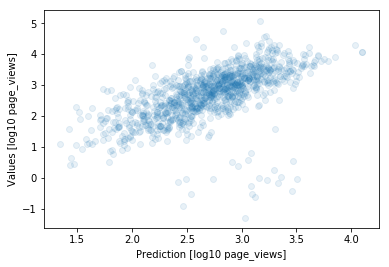

In [123]:
X_columns = ['log10_external_link_count', 'log10_backlink_wikilink_count', 'heading_count', 'log10_wikifile_count', 'log10_wikilink_count', 'log10_word_count']
y_column = ['log10_page_views']

ols_results = reg.fit(X=train_data[X_columns], 
        y=train_data[y_column])

prediction = reg.predict(test_data[X_columns])

print('Coefficients: \n', [name + ': ' + str(val).zfill(4) for name, val in zip(X_columns, reg.coef_[0])])
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))

print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

resampled_data['pageview_prediction'] = reg.predict(resampled_data[X_columns])

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views), alpha=0.1)
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Values [log10 page_views]');

In [ ]:
ols_results.

Coefficients: 
 ['log10_word_count: 0.863448914498842']
Mean squared error: 0.54
Variance score: 0.23


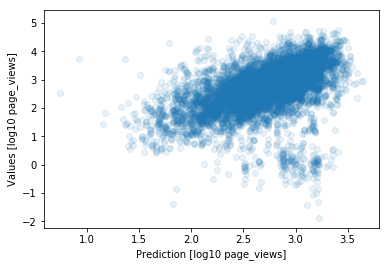

In [109]:
X_columns = ['log10_word_count']
y_column = ['log10_page_views']

reg.fit(X=train_data[X_columns], 
        y=train_data[y_column])

prediction = reg.predict(test_data[X_columns])

print('Coefficients: \n', [name + ': ' + str(val).zfill(4) for name, val in zip(X_columns, reg.coef_[0])])
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))

print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

resampled_data['pageview_prediction'] = reg.predict(resampled_data[X_columns])

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views), alpha=0.1)
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Values [log10 page_views]');

Coefficients: 
 ['log10_external_link_count: 0.41866294761656886', 'log10_wikifile_count: 0.699333944837087', 'log10_word_count: -0.06627001312814429']
Mean squared error: 0.48
Variance score: 0.32


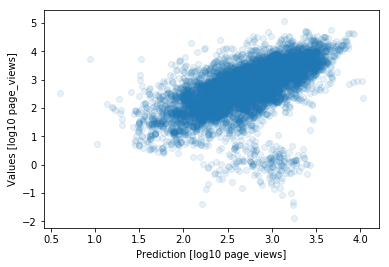

In [112]:
X_columns = ['log10_external_link_count', 'log10_wikifile_count', 'log10_word_count']
y_column = ['log10_page_views']

reg.fit(X=train_data[X_columns], 
        y=train_data[y_column])

prediction = reg.predict(test_data[X_columns])

print('Coefficients: \n', [name + ': ' + str(val).zfill(4) for name, val in zip(X_columns, reg.coef_[0])])
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))

print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

resampled_data['pageview_prediction'] = reg.predict(resampled_data[X_columns])

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views), alpha=0.1)
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Values [log10 page_views]');

In [ ]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count']], 
        y=train_data[['log10_page_views']])

In [ ]:
prediction = reg.predict(test_data[['log10_word_count']])

In [ ]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

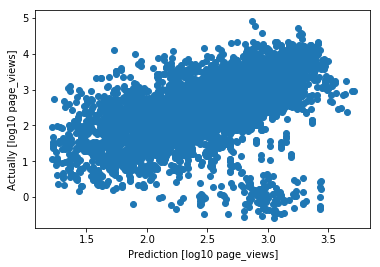

In [241]:
fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

In [242]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count', 'wikifile_count', 'wikilink_count']], 
        y=train_data[['log10_page_views']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [243]:
prediction = reg.predict(test_data[['log10_word_count', 'wikifile_count', 'wikilink_count']])

In [244]:
print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

Coefficients: 
 [[7.94264249e-01 6.30214979e-04 1.00153575e-03]]
Mean squared error: 0.52
Variance score: 0.33


# Individual performance

There is only pointer data for the most current version of a page. Let's confirm that these trends hold for the just the most current data set

In [175]:
resampled_data.set_index('timestamp', inplace=True)
resampled_data_current_stats = resampled_data.loc['2018-12-31']

pages = set(resampled_data_current_stats.page_title) & set(pointer_data.page_title)

resampled_data_current_stats = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(pages)]

# Subsetting the pointer data to only include shared pages

pointer_data = pointer_data[pointer_data.page_title.isin(pages)]
pointer_data.set_index('page_title', inplace=True)

resampled_data_current_stats.reset_index(inplace=True)
resampled_data_current_stats.set_index(['page_title'], inplace=True)

In [184]:
resampled_data_current_stats = pd.concat([pointer_data, resampled_data_current_stats], axis=1)

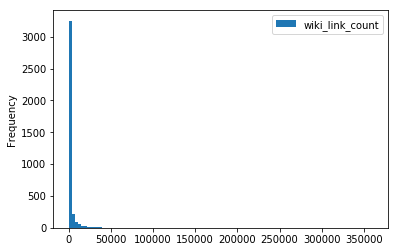

In [186]:
resampled_data_current_stats.plot(y=['wiki_link_count'], kind='hist', bins=100)

This appears skewed 

In [187]:
resampled_data_current_stats['log_wiki_link_count'] = np.log10(resampled_data_current_stats.wiki_link_count)

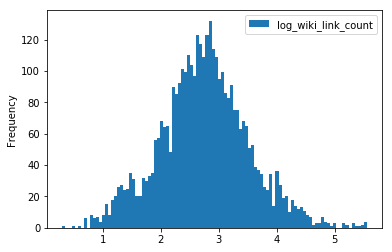

In [188]:
resampled_data_current_stats.plot(y=['log_wiki_link_count'], kind='hist', bins=100)

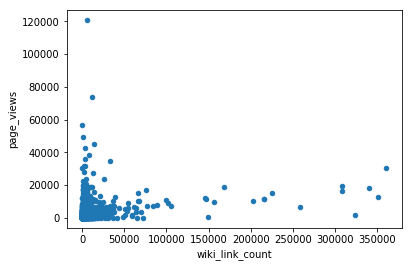

In [189]:
resampled_data_current_stats.plot(x='wiki_link_count', y='page_views', kind='scatter')

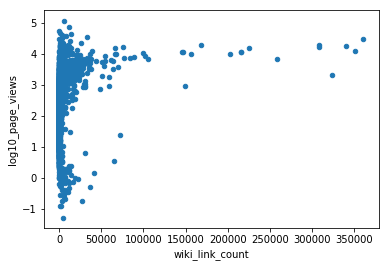

In [190]:
resampled_data_current_stats.plot(x='wiki_link_count', y='log10_page_views', kind='scatter')

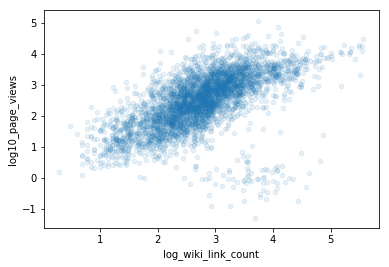

In [192]:
resampled_data_current_stats.plot(x='log_wiki_link_count', y='log10_page_views', kind='scatter', alpha=0.1)

In [193]:
resampled_data_current_stats.reset_index(inplace=True)

train, test = model_selection.train_test_split(resampled_data_current_stats.page_title.unique(), test_size=0.2)

train_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(train)]
test_data = resampled_data_current_stats[resampled_data_current_stats.page_title.isin(test)]

Coefficients: 
 [[0.58169158 0.43207728]]
Mean squared error: 0.48
Variance score: 0.39


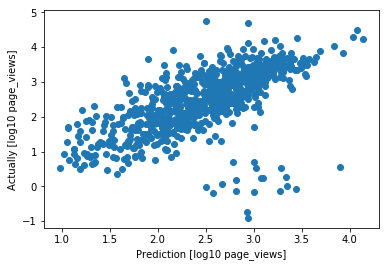

In [194]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count', 'log_wiki_link_count']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count', 'log_wiki_link_count']])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

Coefficients: 
 [[0.99363848]]
Mean squared error: 0.54
Variance score: 0.31


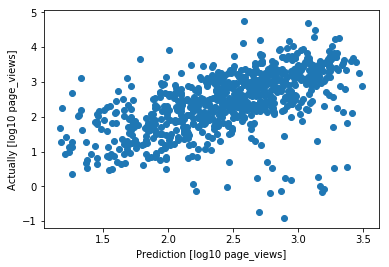

In [195]:
reg = linear_model.LinearRegression()

reg.fit(X=train_data[['log10_word_count']], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[['log10_word_count']])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

Coefficients: 
 [[-2.32261431e-03 -5.15278371e-05  4.79183735e-01  1.43241446e-03
   4.27857130e-01 -1.40450353e-05  0.00000000e+00]]
Mean squared error: 0.47
Variance score: 0.40


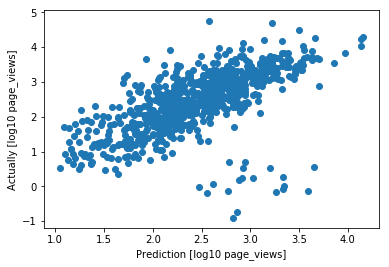

In [196]:
reg = linear_model.LinearRegression()

metrics = ['wikilink_count', 'wikifile_count', 'log10_word_count', 'external_link_count', 
           'log_wiki_link_count', 'talk_link_count','wikipeida_count']

reg.fit(X=train_data[metrics], 
        y=train_data[['log10_page_views']])

prediction = reg.predict(test_data[metrics])

print('Coefficients: \n', reg.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(test_data.log10_page_views, prediction))
print('Variance score: %.2f' % r2_score(test_data.log10_page_views, prediction))

fig, ax = plt.subplots()
ax.scatter(x=np.array(prediction), y=np.array(test_data.log10_page_views))
ax.set_xlabel('Prediction [log10 page_views]');
ax.set_ylabel('Actually [log10 page_views]');

## Does an increase in page size cause an increase in page viewership?

In [101]:
combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)

resampled_data = combined_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('1d').mean()

# remove data that is mostly na

pages = [page for page, df in resampled_data.groupby('page_title') if df.character_count.isna().sum()>1100]

resampled_data = resampled_data.drop(pages, level=0)

# calculate std of values of interest
resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)
std_data = resampled_data[['page_title', 'external_link_count',
                                'heading_count', 'page_views',
                                'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').std()


resampled_data.reset_index(inplace=True)
resampled_data.set_index('timestamp', inplace=True)
resampled_data = resampled_data[['page_title', 'character_count', 'external_link_count',
                   'heading_count', 'page_views',
                   'wikifile_count', 'wikilink_count', 'word_count']].groupby('page_title').resample('7d').mean()


resampled_data.reset_index(inplace=True)
resampled_data.set_index(['page_title', 'timestamp'], inplace=True)

resampled_data['page_views_std'] = std_data['page_views']

resampled_data.reset_index(inplace=True)

resampled_data.set_index('timestamp', inplace=True)
resampled_data = resampled_data.groupby('page_title').apply(lambda x: x.ffill())



In [103]:
resampled_data.reset_index(inplace=True)

In [104]:
resampled_data['word_count_delta'] = resampled_data.groupby('page_title')['word_count'].diff()
resampled_data['page_views_delta'] = resampled_data.groupby('page_title')['page_views'].diff()

In [106]:
resampled_data.dropna(inplace=True)

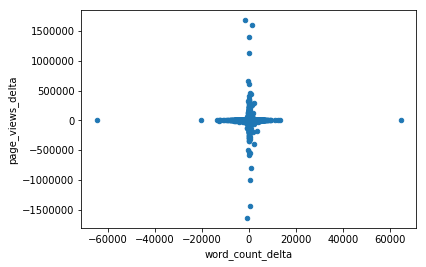

In [107]:
resampled_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter')

(-1000, 1000)

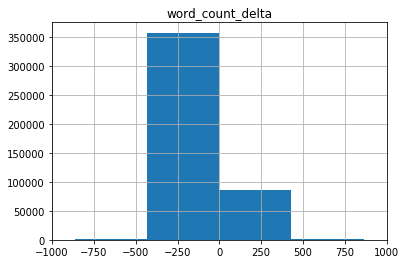

In [120]:
fig, ax = plt.subplots()
resampled_data.hist(column='word_count_delta', bins=300, ax=ax)
ax.set_xlim(-1000, 1000)

In [124]:
resampled_data = resampled_data[(resampled_data.word_count_delta < 750) &
                                (resampled_data.word_count_delta > -750) &
                                (resampled_data.page_views_delta < )]

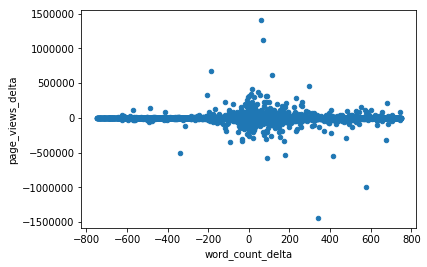

In [134]:
resampled_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter')

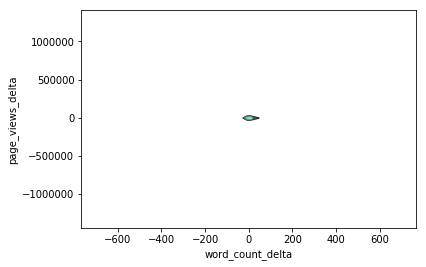

In [135]:
sns.kdeplot(data=resampled_data.word_count_delta, data2=resampled_data.page_views_delta )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7D645C978>],
      dtype=object)

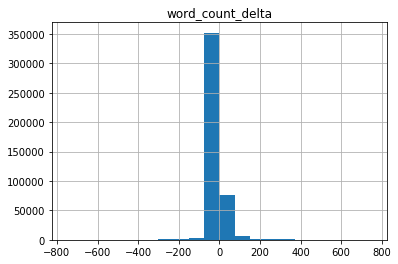

In [127]:
fig, ax = plt.subplots()
resampled_data.hist(column='word_count_delta', bins=20, ax=ax)
# ax.set_xlim(-1000, 1000)

(-250, 250)

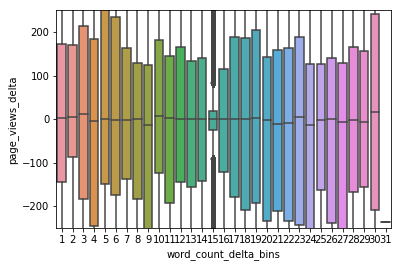

In [133]:
_, bins = np.histogram(resampled_data.word_count_delta, bins=30)
resampled_data['word_count_delta_bins'] = np.digitize(resampled_data.word_count_delta, bins=bins)

fig, ax = plt.subplots()

sns.boxplot(x='word_count_delta_bins', y='page_views_delta', data=resampled_data, ax = ax)
ax.set_ylim(-250, 250)

In [ ]:
resampled_data.word_count_delta

KeyboardInterrupt: 

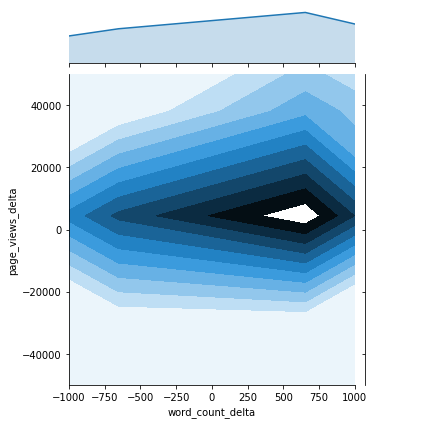

In [109]:
sns.jointplot(x=resampled_data.word_count_delta, y=resampled_data.page_views_delta, kind='kde', xlim=(-1000, 1000),
              ylim=(-50000, 50000) );


In [311]:
# resampled_data.reset_index(inplace=True)
reindexed_data = resampled_data.copy()
reindexed_data.timestamp = reindexed_data.timestamp + pd.to_timedelta(10, unit='D')

In [312]:
resampled_data.set_index(['page_title', 'timestamp'], inplace=True)

In [313]:
reindexed_data.set_index(['page_title', 'timestamp'], inplace=True)

In [314]:
reindexed_data = reindexed_data[['page_views', 'page_views_delta', 'word_count', 'word_count_delta']]
reindexed_data.columns = ['last_week_page_views', 'last_week_page_views_delta',  
                          'last_week_word_count', 'last_week_word_count_delta']

In [315]:
last_week_trends_data = pd.concat([resampled_data, reindexed_data], axis=1)

In [316]:
last_week_trends_data.dropna(inplace=True)

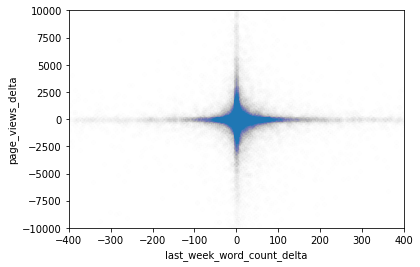

In [317]:
last_week_trends_data.plot(x='last_week_word_count_delta', y='page_views_delta', kind='scatter', alpha=0.005,
                          xlim=(-400, 400), ylim=(-10000, 10000))

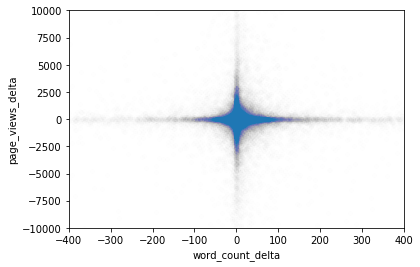

In [318]:
last_week_trends_data.plot(x='word_count_delta', y='page_views_delta', kind='scatter', alpha=0.005,
                          xlim=(-400, 400), ylim=(-10000, 10000))

In [319]:
# sns.jointplot(x=last_week_trends_data.last_week_word_count_delta, y=last_week_trends_data.page_views_delta, 
#               kind='kde', xlim=(-400, 400), ylim=(-20000, 20000));


In [320]:
# sns.jointplot(x=last_week_trends_data.word_count_delta, y=last_week_trends_data.page_views_delta, kind='kde', 
#               xlim=(-400, 400), ylim=(20000, -20000));

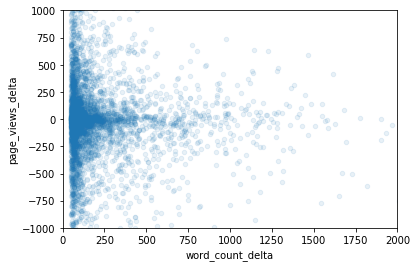

In [328]:
last_week_trends_data[last_week_trends_data.word_count_delta > 50].plot(x='word_count_delta', 
                                                                        y='page_views_delta', 
                                                                        kind='scatter', alpha=0.1, 
                                                                        xlim=(0, 2000), ylim=(-1000, 1000))

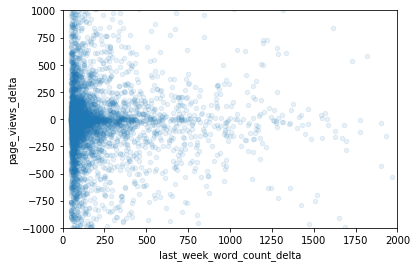

In [330]:
last_week_trends_data[last_week_trends_data.last_week_word_count_delta > 50].plot(x='last_week_word_count_delta', 
                                                                        y='page_views_delta', 
                                                                        kind='scatter', alpha=0.1, 
                                                                        xlim=(0, 2000), ylim=(-1000, 1000))

In [335]:
len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50) &
                      (last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50)])

0.43242753623188407

In [336]:
len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50) &
                          -(last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.last_week_word_count_delta > 50)])

0.567572463768116

In [337]:
len(last_week_trends_data[(last_week_trends_data.word_count_delta > 50) &
                          (last_week_trends_data.page_views_delta > 0)])/len(last_week_trends_data[(last_week_trends_data.word_count_delta > 50)])

0.46946216955332726

In [178]:
pd.concat([resampled_data, reindexed_data])

c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,external_link_count,heading_count,index,last_week_page_views,last_week_page_views_delta,page_views,page_views_delta,page_views_std,wikifile_count,wikilink_count,word_count,word_count_delta
timestamp,,,,,,,,,,,,
2015-07-31,10.000000,4.0,1.0,NaN,NaN,13.375000,-2.261364,5.314314,19.531250,0.0,477.593750,1.593750
2015-08-30,10.000000,4.0,2.0,NaN,NaN,15.566667,2.191667,5.399127,20.000000,0.0,479.000000,1.406250
2015-09-29,10.000000,4.0,3.0,NaN,NaN,12.700000,-2.866667,4.579941,20.000000,0.0,479.000000,0.000000
2015-10-29,10.000000,4.0,4.0,NaN,NaN,15.833333,3.133333,5.843259,20.000000,0.0,479.000000,0.000000
2015-11-28,10.176471,4.0,5.0,NaN,NaN,15.882353,0.049020,5.623353,19.852941,0.0,479.411765,0.411765
2015-12-28,12.000000,4.0,6.0,NaN,NaN,13.533333,-2.349020,4.576803,19.000000,0.0,483.000000,3.588235
2016-01-27,12.000000,4.0,7.0,NaN,NaN,14.709677,1.176344,5.556939,20.806452,0.0,483.903226,0.903226
2016-02-26,12.000000,4.0,8.0,NaN,NaN,14.000000,-0.709677,4.417832,23.000000,0.0,485.000000,1.096774
2016-03-27,12.000000,4.0,9.0,NaN,NaN,12.666667,-1.333333,4.002873,23.000000,0.0,485.000000,0.000000


In [170]:
combined_data.dropna()

,,external_link_count,heading_count,index,last_week_page_views,last_week_page_views_delta,page_views,page_views_delta,page_views_std,wikifile_count,wikilink_count,word_count,word_count_delta
page_title,timestamp,,,,,,,,,,,,


In [59]:
for page, df in resampled_data.groupby('page_title'):
    

,page_title,timestamp,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
1,032c,2015-07-08,10.000000,4.000000,21.000000,19.000000,0.0,476.000000
2,032c,2015-07-15,10.000000,4.000000,11.714286,19.000000,0.0,476.000000
3,032c,2015-07-22,10.000000,4.000000,14.857143,19.000000,0.0,476.000000
4,032c,2015-07-29,10.000000,4.000000,13.714286,19.000000,0.0,476.000000
5,032c,2015-08-05,10.000000,4.000000,10.285714,19.000000,0.0,476.000000
6,032c,2015-08-12,10.000000,4.000000,15.888889,19.666667,0.0,478.000000
7,032c,2015-08-19,10.000000,4.000000,12.428571,20.000000,0.0,479.000000
8,032c,2015-08-26,10.000000,4.000000,15.571429,20.000000,0.0,479.000000
9,032c,2015-09-02,10.000000,4.000000,16.428571,20.000000,0.0,479.000000
10,032c,2015-09-09,10.000000,4.000000,17.285714,20.000000,0.0,479.000000


In [ ]:
standard_deviation = combined_data[['page_views', 'page_title']].groupby('page_title').resample('1w').std()

In [243]:
resampled_data.dropna(inplace=True)

In [244]:
resampled_data

,page_title,timestamp,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
1,032c,2015-07-12,10.000000,4.000000,20.900000,19.000000,0.0,476.000000
2,032c,2015-07-19,10.000000,4.000000,11.428571,19.000000,0.0,476.000000
3,032c,2015-07-26,10.000000,4.000000,14.428571,19.000000,0.0,476.000000
4,032c,2015-08-02,10.000000,4.000000,16.142857,19.000000,0.0,476.000000
5,032c,2015-08-09,10.000000,4.000000,10.000000,19.000000,0.0,476.000000
6,032c,2015-08-16,10.000000,4.000000,15.555556,19.444444,0.0,477.333333
7,032c,2015-08-23,10.000000,4.000000,11.428571,20.000000,0.0,479.000000
8,032c,2015-08-30,10.000000,4.000000,16.285714,20.000000,0.0,479.000000
9,032c,2015-09-06,10.000000,4.000000,15.714286,20.000000,0.0,479.000000
10,032c,2015-09-13,10.000000,4.000000,14.571429,20.000000,0.0,479.000000
